© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/phd_students/seleznova/index.html) 2022

https://github.com/mselezniova/MSML22

Distributed under the [Creative Commons Attribution License](https://creativecommons.org/licenses/by/4.0/)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib
import matplotlib.pyplot as plt

import os

import numpy as np
import pandas as pd


import sys
sys.path.append('../../')

from models import LinearBinaryClassification, LogisticRegression, RidgeClassification

# Introduction

Suppose we have a *linearly separable* dataset for binary classification, i.e. we can perfectly separate the two classes by a hyperplane. Typically, there are infinitely many separating hyperplanes in this case. Then we may ask a question: **What is the best choice of the hyperplane?**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/1920px-Svm_separating_hyperplanes_%28SVG%29.svg.png" alt="svm" width="400"/>

Source: [https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:Svm_separating_hyperplanes_(SVG).svg](https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:Svm_separating_hyperplanes_(SVG).svg)

We already know that different machine learning methods offer different answers to this question. Recall that binary classification with squared loss chooses a hyperplane that minimizes the squared loss of the corresponding regression problem, which is unique for underparametrized least squares with linearly independent features. One may view this as **implicit regularization**, since the classication model prefers a certain solution over the other ones (with the same classification accuracy). Adding **explicit regularization**, e.g. Ridge regularization, to least squares classification will further prefer a hyperplane with smaller norm of the coefficients.

Let us load the Iris dataset and compare the hyperplanes chosen by three different models implemented in previous classes: ```LinearBinaryClassification```, ```RidgeClassification``` and ```LogisticRegression```.

In [2]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `iris_data_set.csv`...


In [3]:
df['class'] = df['iris type'].replace(
    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
    [-1, 1, 1])

X = df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
Y = df['class'].to_numpy()

In [4]:
w = [0]*X.shape[1]
b = 0

ls = LinearBinaryClassification(w, b)
ls.train(X,Y,lr = 1e-2, num_iter = 5000)

ridge = RidgeClassification(w, b, l = 0.1)
ridge.train(X,Y,lr = 1e-2, num_iter = 5000)

logreg = LogisticRegression(w, b)
logreg.train(X,np.where(Y>0,1,0),lr = 1e-2, num_iter = 5000)

print(f"Least squares classification accuracy:{ls.history[-1]['accuracy']}")
print(f"Ridge classification accuracy:{ridge.history[-1]['accuracy']}")
print(f"Logistic regression accuracy:{logreg.history[-1]['accuracy']}")

Least squares classification accuracy:1.0
Ridge classification accuracy:1.0
Logistic regression accuracy:1.0


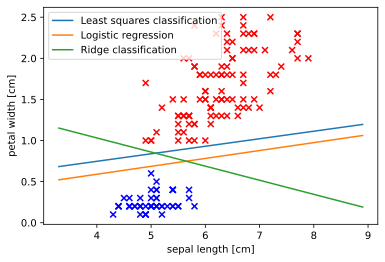

In [5]:
fig, ax = plt.subplots()

colors = df['class'].replace([-1,1],['blue','red'])
plt.scatter(X[:, 0], X[:, 1], marker='x', color=colors)

# Plot decision boundaries

x1_min = X[:, 0].min() - 1
x1_max = X[:, 0].max() + 1
x2_min = X[:, 1].min() - 1
x2_max = X[:, 1].max() + 1

x1 = np.linspace(x1_min,x1_max,100)

for model, label in zip([ls, logreg, ridge],['Least squares classification', 
                                             'Logistic regression',
                                             'Ridge classification']):
    w1 , w2 = model._w
    b = model._b

    plt.plot(x1, -b/w2-w1/w2*x1, label = label)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend()

# Support Vector Machines (SVM)

**Support Vector Machines (SVM)** has a different rule to choose a solution: it prefers a hyperplane with the **maximal margin**, i.e. maximal distance from the separating hyperplane to the closest data points (from both classes). 

Assume we have a hyperplane $H = \{x\in \mathbb{R}^d|\langle w, x \rangle + b = 0\}$ for some coefficients $w\in\mathbb{R}$, $b\in\mathbb{R}$. Then the distance from arbitrary point $x\in\mathbb{R}^d$ to $H$ (length of the projection of $x$ onto the normal vector $w$) is given by:

$$dist(x,H) = \dfrac{|\langle w, x \rangle + b|}{\|w\|_2}$$

And the **margin** of $H$ with respect to a dataset $(X,Y) = \{(x_i,y_i)\}_{i=1,\dots,N}$ is defined as:

$$M(w,b,X) = \min_{x_i \in X} \dfrac{|\langle w, x_i \rangle + b|}{\|w\|_2}$$

Therefore, the optimization problem of a maximal margin classifier can be formulated as follows:

$$ \underset{w, b}{\operatorname{argmax}}\dfrac{1}{\|w\|_2}\min_{x_i\in X}{|\langle w, x_i \rangle + b|} \quad \text{ subject to }  \quad \forall i\in\{1,\dots, N\}, y_i(\langle w, x_i \rangle + b) \geq 0 $$

Now notice that the margin is **scale invariant**, i.e. 

$$\forall \alpha \neq 0, M(\alpha w, \alpha b, X) = M( w, b, X) $$

Therefore, our classifier still has infinitely many solutions, which differ only in the scale of parameters. Let us the fix the scale in the simplest possible way:

$$\|w\|_2 M(w,b,X) = \min_{x_i \in X} {|\langle w, x_i \rangle + b|} = 1$$

With this choice of scale, all the points from class $1$ satisfy $\langle w, x_i \rangle + b \geq 1$ as $1$ and all the points from class $-1$ satisfy $\langle w, x_i \rangle + b \leq -1 $. Then the optimization problem simplifies to: 

$$ \underset{w, b}{\operatorname{argmin}}{\|w\|^2_2} \quad \text{ subject to } \quad \forall i\in\{1,\dots, N\}, y_i(\langle w, x_i \rangle + b) \geq 1, $$

where we noticed that maximizing $1/\|w\|_2$ is equivalent to minimizing $\|w\|_2$ and also $\|w\|^2_2$. This model is called **hard-margin SVM**, since it does not accept any errors: it only has a solution when a separating hyperplane exists. Therefore, it is only useful for linearly separable data, which does not occur so often in practice. 


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1920px-SVM_margin.png" alt="svm" width="400"/>

Source: [https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:SVM_margin.png](https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:SVM_margin.png)

**How to solve the hard-margin SVM problem?** Hard-margin SVM optimization problem is an example of [quadratic programming](https://en.wikipedia.org/wiki/Quadratic_programming) (QP), which is a common problem in mathematical optimization. There exist multiple QP solvers, which are designed to efficiently solve QP with particular properties. There is also an algorithm specifically designed to solve the SVM problem called [sequential minimal optimization (SMO)](https://en.wikipedia.org/wiki/Sequential_minimal_optimization) (SMO solves the **dual problem** of SVM, which we will cover in the next class). SMO is implemented in [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) and is a default choice for SVM optimization in, e.g., scikit-learn. QP solvers are generally very fast and return (almost) optimal solutions (on "good" problems, such as SVM).
However, QP solvers (including SMO) are computationally infeasible for very large datasets since they typically require seeing all the data at once. 


**What are the "support vectors" in SVM?** Support vectors are the points with minimal margin, i.e. those with 
$$y_i(\langle w,x_i \rangle + b)  = 1$$
One can see that the support vectors determine the position of the separating hyperplane, while all the other vectors do not influence the SVM solution. 

## Soft-margin SVM

When the data is not linearly separable hard-margin SVM does not have a solution. How to generalize SVM to this case? We can cut the data samples some slack! Let us introduce slack variables $\xi_i, i\in\{1,\dots,N\}$, which indicate how much the margin constraint can be violated for each sample $x_i$. Then we can formulate a new optimization problem, called **soft-margin SVM**, which allows errors but penalizes them:

$$ \underset{w, b}{\operatorname{argmin}}{\|w\|^2_2} + C \sum_{i=1}^N \xi_i$$

$$\text{s.t.} \quad \forall i\in\{1,\dots, N\}, \quad y_i(\langle w, x_i \rangle + b) \geq 1 - \xi_i,$$

$$\forall i\in\{1,\dots, N\}, \quad \xi_i \geq 0$$

Here we introduced a hyperparameter $C$, which, similarly to regularization hyperparameters discussed in previous classes, controls the importance of each part of the loss function. When $C$ is very large, SVM is very strict and prefers a smaller margin hyperplane that makes very few errors. If $C$ is small, the SVM may prefer to allow some errors in order to get a larger margin.

### Unconstrained optimization problem

Now we notice that the soft-margin SVM problem can be reformulated as an unconstrained problem. One can see that the solution requires minimal values of $\xi_i$, such that the constraints still hold. Therefore, the constraints should hold as equalities in the solution of soft-margin SVM:

$$\xi_i = \max\bigl(0,1-y_i(\langle w,x_i \rangle + b)\bigr)$$

Plugging this expression into the objective function we get the following unconstrained problem:

$$\underset{w, b}{\operatorname{argmin}}{\|w\|^2_2} + C \sum_{i=1}^N \max\bigl(0,1-y_i(\langle w,x_i \rangle + b)\bigr)$$

This optimization problem has a very familiar form: it is exactly the same as a GLM with Ridge regularization (with the hyperparameter given by $1/C$) and the so-called **hinge loss** given by:

$$\mathcal{L}(y,y') = \max\bigl(0,1-yy'\bigr)$$

This problem can be solved using gradient descent, just as all the other GLMs that we considered before.

To implement soft-margin SVM model with GD training, we need to first find the gradients of the risk function. As with other piecewise-linear functions, we will assume that gradients are given by one of the subgradients in the breaking point:

$$\dfrac{\partial \mathcal L}{\partial y'} = \begin{cases}
-y, \text{ if } 1-yy'>0\\
0 , \text{ if } 1-yy'\leq 0\\
\end{cases}$$

Therefore, we have the following expressions for the loss gradients:

$$\nabla_w \mathcal{R}(w,b,X,Y) = 2w - C\sum_{i=1}^N \mathbb{1}[1-y_ih(x_i)>0]y_ix_i $$
$$\nabla_b \mathcal{R}(w,b,X,Y) = - C\sum_{i=1}^N \mathbb{1}[1-y_ih(x_i)>0]y_i $$

In [6]:
class LinearSVM(LinearBinaryClassification):

    def __init__(self, w, b, C=1.0):
        self._w = np.array(w, dtype=float)
        self._b = np.array(b, dtype=float)
        self.history = [{'w': self._w.copy(),
                         'b': self._b.copy(),
                         'loss': None,
                         'accuracy': None}]
        self.C = C

    def loss(self, X, Y):
        
        pred = X@self._w+self._b
        slack = (1 - Y * pred)
        
        return np.dot(self._w,self._w) + self.C*np.sum(slack[slack > 0])
    
    def loss_grad(self, X,Y):
        
        pred = X@self._w+self._b
        slack = (1 - Y * pred)
        
        db_slack = -Y.reshape(-1, 1)
        db_hinge = np.sum(db_slack[slack > 0])

        dw_slack = db_slack * X
        dw_hinge = np.sum(dw_slack[slack > 0], axis=0)
        
        return 2*self._w + self.C*dw_hinge, self.C*db_hinge

In [10]:
w = [0]*X.shape[1]
b = 0

svm = LinearSVM(w, b, C=100.0)
svm.train(X,Y,lr = 1e-6, num_iter = 200000)

(array([-0.2040995 ,  5.51104903]), array(-3.2863))

The final train accuracy: 100.0%


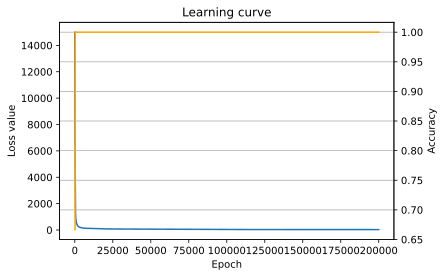

In [11]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in svm.history]
acc_history = [h['accuracy'] for h in svm.history]

ax.plot(range(len(svm.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(svm.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')

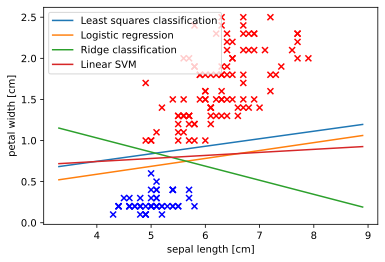

In [12]:
fig, ax = plt.subplots()

colors = df['class'].replace([-1,1],['blue','red'])
plt.scatter(X[:, 0], X[:, 1], marker='x', color=colors)

# Plot decision boundaries

x1_min = X[:, 0].min() - 1
x1_max = X[:, 0].max() + 1
x2_min = X[:, 1].min() - 1
x2_max = X[:, 1].max() + 1

x1 = np.linspace(x1_min,x1_max,100)

for model, label in zip([ls, logreg, ridge, svm],['Least squares classification', 
                                             'Logistic regression',
                                             'Ridge classification',
                                             'Linear SVM']):
    w1 , w2 = model._w
    b = model._b

    plt.plot(x1, -b/w2-w1/w2*x1, label = label)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend()

# Exercise

Implement **one-vs-rest** multiclass linear SVM model based on our ```LinearMulticlassClassification``` class. The output of the model is given by:

$$h(x) = \underset{k\in\{1,\dots,K\}}{\operatorname{argmax}} \langle w_k, x \rangle + b_k,$$

where $K\in\mathbb{N}$ is the number of classes, $d\in\mathbb{N}$ is the input dimension, $W=[w_1,\dots,w_K]\in\mathbb{R}^{d\times K}$ is the matrix of weights and $B = [b_1,\dots,b_2]\in\mathbb{R}^K$ is the vector of biases. The risk function is the sum of all the risks corresponding to binary models:


$$\min_{W,B}{\|W\|^2_2} + C \sum_{i=1}^N\sum_{k=1}^K \max\bigl(0,1-y_i[k](\langle w_k,x_i \rangle + b_k)\bigr) = $$

$$= \min_{W,B}{\|W\|^2_2} + C \|\max\bigl(0,1-Y\odot(XW+B)\bigr)\|_1$$